# Introduction
It is my intention in this file to teach myself about count data models and the ins and outs of this type of regression modeling with some examples and discussions of what is what and what they mean. Fingers crossed! I will then try to apply what I learned to traffic crash data in order to develop safety performance functions per the guidelines in [HSM](https://www.highwaysafetymanual.org/Pages/default.aspx)

# Types of Models
Alright, so a little intro for myself on the various types of models on the data and why and how count models are different from the rest!
Obviously there area ton of modeling techniques, and what choice of model to use depends on the nature of the data and the research question you're dealing with. For example, 
1. Linear regression: To model the relationship between a **continuous dependent variable** and one or more independent variables.
2. Logistic regression: To model a **binary or categorical dependent variable** where the goal is to predict the probability of a certain outcome.
3. Poisson regression: To model **count data** where the goal is to predict the rate at which events occur.
4. Negative binomial regression, NB in short: To model **over-dispersed count data** where simple Poisson modeling technique is not reliable due to limitation in the modeling assumptions.
5. Time series analysis: To model **data that changes over time**, such as stock prices or weather patterns.
6. Survival analysis: To model the **time until an event occurs**, such as time until a patient dies or time until a machine fails.
7. Random forest: An ML technique to model **complex relationships between variables** usually where there are many independent variables.
8. Neural networks: Also an ML technique used to model **complex relationships between variables** similar to random forest for when there are many independent variables.

Why I am doing count modeling (i.e. will be doing # 3 and 4 and maybe others from above) is because that is my professional subject area with regards to traffic crash counts and how to predict them based on various types of categories which will come up later on.

So, I know that linear regression is not my modeling technique becasue <u>count data is discrete, non-negative, and often follows a skewed distribution</u>. <u>Linear regression models assume that the dependent variable is continuous and normally distributed</u>, which is not the case for count data. Using linear regression for count data violates the assumptions of the model, leading to biased and inefficient estimates, incorrect standard errors, and unreliable hypothesis tests. Furthermore, the predicted values can be negative, which is not possible for count data.

I also know that I can't use logistic regression for count data because that model assumes that the response variable follows a *Bernoulli distribution*, which is a discrete probability distribution that models the probability of a single event occurring in a single trial. But, count data often follows a Poisson or negative binomial distribution.

Nonetheless, let's pull in some count data and try various models and discuss results.

# Importing Libraries / Setting Options
I update this section every time I need to import a new library as I make progress. I just have an obsession to do all of the imports and options for how to show numbers, digits, outputs in one place rather than sporadically throughout my work.

In [ ]:
# Loading multiple libraries as needed in one line
lapply(c("tidyverse", "skimr", "AER", "ggplot2", "psych", "MASS"), 
       require, 
       character.only = T,
      quietly = TRUE) # to suppress output messages and warnings

# Have enough width for output so some are not shifted to next line!
options(width = 120)

In [29]:
# Specify number of significant decimal digits when printing output
options(digits = 3)

Here are several count data that can come handy, although I am not using all of them. Just writing them down for reference:
- Number of rooms data from the Boston dataset in `MASS` library
- Number of seizures for Epileptics from Epil datasets in `MASS` library
- Number of sattelite (unpaired) crabs from the Crabs dataset in `glmbb` library
- Number of claims from Insurance dataset in `countreg` library
- Number of affairs from Affairs dataset in `AER` library (AER for Applied Econometrics with R)
- Number of visits from DoctorVisits dataset in `AER` library
- Number of doctor visits from Medicaid1986 dataset in `AER` library
- Number of accidents from ShipAccidents dataset in `AER` library
- Number of derogetory reports from the CreditCard dataset in `AER` library
- Number of articles from PhDPublications dataset in `AER` library
- Number of kids from GSS7402 dataset in `AER` library
- Several count variables in NMES1988 dataset (medical care) `AER` library
- Several count variables in EquationCitations datasets in `AER` library
- A count dataset from this [Kaggle Page](https://www.kaggle.com/datasets/pablomonleon/montreal-bike-lanes) that contains information on the Number of bicycles that used certain bicycle lanes in Montreal in the year 2015. I removed a couple columns and changed some of the names for simplicity.
- A [roadway inventory dataset](https://geo-massdot.opendata.arcgis.com/datasets/MassDOT::road-inventory/about) from MassDOT's open data website. This data includes annual average daily tarffic (AADT) for various roads in MA along with other road properties for each segment. I made the data much lighter to handle by removing many rows some variables for the sake of my learning.

I am going to use the PhDPublications dataset to start my count modeling with.

In [3]:
bikes  <-  read.csv("MontrealBL.csv")
aadt  <- read.csv("RoadInventorysample.csv")
aadt <- aadt[complete.cases(aadt$AADT),]

In [3]:
data("PhDPublications")

# EDA / Descriptive Statistics
First, let's look at the dataset, the variables and their types in the PhDPublications dataset. Then Let's take a quick look at some descriptive statistics about these variables and some visualization to know our data better as well.

In [11]:
print(head(PhDPublications, 3)) # I like using print but don't have to

  articles gender married kids prestige mentor
1        0   male     yes    0     2.52      7
2        0 female      no    0     2.05      6
3        0 female      no    0     3.75      6


There is the number `articles` (my count variable!). Then there are the binary variables of `gender` and `married`. There is another count variable `kids` which in this context is more like an explanatory variable than response. `prestige` is a continuous variable tha shows the prestige score of the program, and `mentor` is another nice count variable which shows the articles count published by the student's mentor.

In [12]:
glimpse(PhDPublications)

Rows: 915
Columns: 6
$ articles <int> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0…
$ gender   <fct> male, female, female, male, female, female, female, male, mal…
$ married  <fct> yes, no, no, yes, no, yes, no, yes, no, yes, no, no, yes, yes…
$ kids     <int> 0, 0, 0, 1, 0, 2, 0, 2, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 0, 0, 0…
$ prestige <dbl> 2.520, 2.050, 3.750, 1.180, 3.750, 3.590, 3.190, 2.960, 4.620…
$ mentor   <int> 7, 6, 6, 3, 26, 2, 3, 4, 6, 0, 14, 13, 3, 4, 0, 1, 7, 13, 7, …


In [31]:
summary(PhDPublications)

    articles        gender    married        kids          prestige        mentor    
 Min.   : 0.00   male  :494   no :309   Min.   :0.000   Min.   :0.75   Min.   : 0.0  
 1st Qu.: 0.00   female:421   yes:606   1st Qu.:0.000   1st Qu.:2.26   1st Qu.: 3.0  
 Median : 1.00                          Median :0.000   Median :3.15   Median : 6.0  
 Mean   : 1.69                          Mean   :0.495   Mean   :3.10   Mean   : 8.8  
 3rd Qu.: 2.00                          3rd Qu.:1.000   3rd Qu.:3.92   3rd Qu.:12.0  
 Max.   :19.00                          Max.   :3.000   Max.   :4.62   Max.   :77.0  

In [30]:
print(describe(PhDPublications))

         vars   n mean   sd median trimmed  mad  min   max range  skew kurtosis   se
articles    1 915 1.69 1.93   1.00    1.39 1.48 0.00 19.00 19.00  2.51    12.63 0.06
gender*     2 915 1.46 0.50   1.00    1.45 0.00 1.00  2.00  1.00  0.16    -1.98 0.02
married*    3 915 1.66 0.47   2.00    1.70 0.00 1.00  2.00  1.00 -0.69    -1.53 0.02
kids        4 915 0.50 0.76   0.00    0.35 0.00 0.00  3.00  3.00  1.37     0.89 0.03
prestige    5 915 3.10 0.98   3.15    3.13 1.32 0.75  4.62  3.86 -0.12    -1.08 0.03
mentor      6 915 8.77 9.48   6.00    7.10 5.93 0.00 77.00 77.00  2.42     8.37 0.31


In [38]:
cat("frequency table of the number of articles:")
table(PhDPublications$articles)

frequency table of the number of articles:


  0   1   2   3   4   5   6   7   8   9  10  11  12  16  19 
275 246 178  84  67  27  17  12   1   2   1   1   2   1   1 

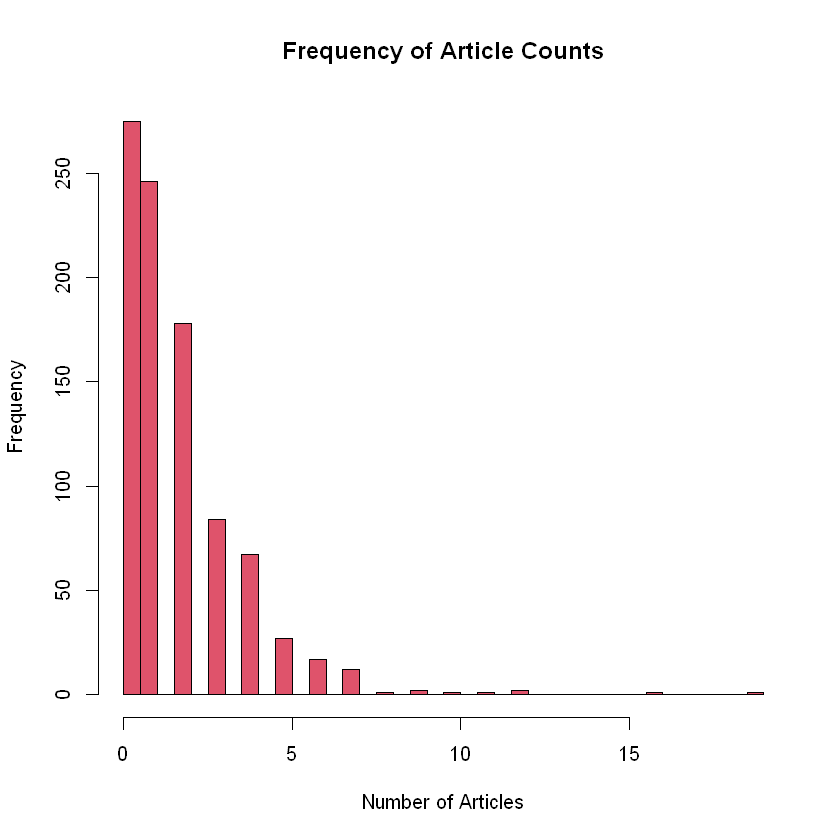

In [4]:
hist(PhDPublications$articles, 
     breaks = 30,
     main = "Frequency of Article Counts",
     col = 2,
     xlab = "Number of Articles")

- Number of articles published by students vary between 0-19 with an average of ~ 1.7 and intersetingly. With median of smaller than mean and so large a range, this is skewed to the right distribution and the skew and kutosis shows this too.
- Number of articles for the mentors vary between 0-77 with an average of ~ 8.8. 
- Number of kids was not so high with a max of 3

Let's see how things are once grouped for gender and/or marital status, specifically, since I'm dealing with count data and overdispersion usually bites me when dealing with count data! I would like to look at mean and variance specifically becasue one of the assumptions when working with Poisson model (which is used to model count data, more details later) is that mean and variance are equal, so keeping an eye on these two rascals may provide some insight.

In [7]:
PhDPublications %>% 
     group_by(married, gender) %>% 
     summarise(Average = mean(articles),
               Variance = var(articles),
               VarOverMean = var(articles)/mean(articles), # see the ratio of variance/mean for insight
               Median = median(articles),
               Minimum = min(articles),
               Maximum = max(articles),
               Range = max(articles) - min(articles),
               Counts = n(),
               .groups = 'drop') %>% 
                print()

# A tibble: 4 × 10
  married gender Average Variance VarOverMean Median Minimum Maximum Range Counts
  <fct>   <fct>    <dbl>    <dbl>       <dbl>  <dbl>   <int>   <int> <int>  <int>
1 no      male      1.95     4.05        2.08      1       0       7     7    113
2 no      female    1.39     2.28        1.64      1       0       7     7    196
3 yes     male      1.86     4.97        2.66      1       0      19    19    381
4 yes     female    1.54     2.52        1.63      1       0      10    10    225


This stat tell me that:
- my data contains almost 4 times the number of married males than single males and twice that of single females! 
- in general seems maximum number of articles for married people are higher! Does that mean married life is more encouraging?
- average number of articles is highers for single males followed by married males! Seems men are doing better than females. 
- it seems maybe there is an interaction effect between gender and marital status.
- because there is a good skew in the distribution median is a better measure of central tendency and we it for all is 1

# EDA / Visual
this was just some observations made based on the data, and we will see how each variable or their interaction affects number of articles published. for the moment, let's look at the histogram for the same groupings:

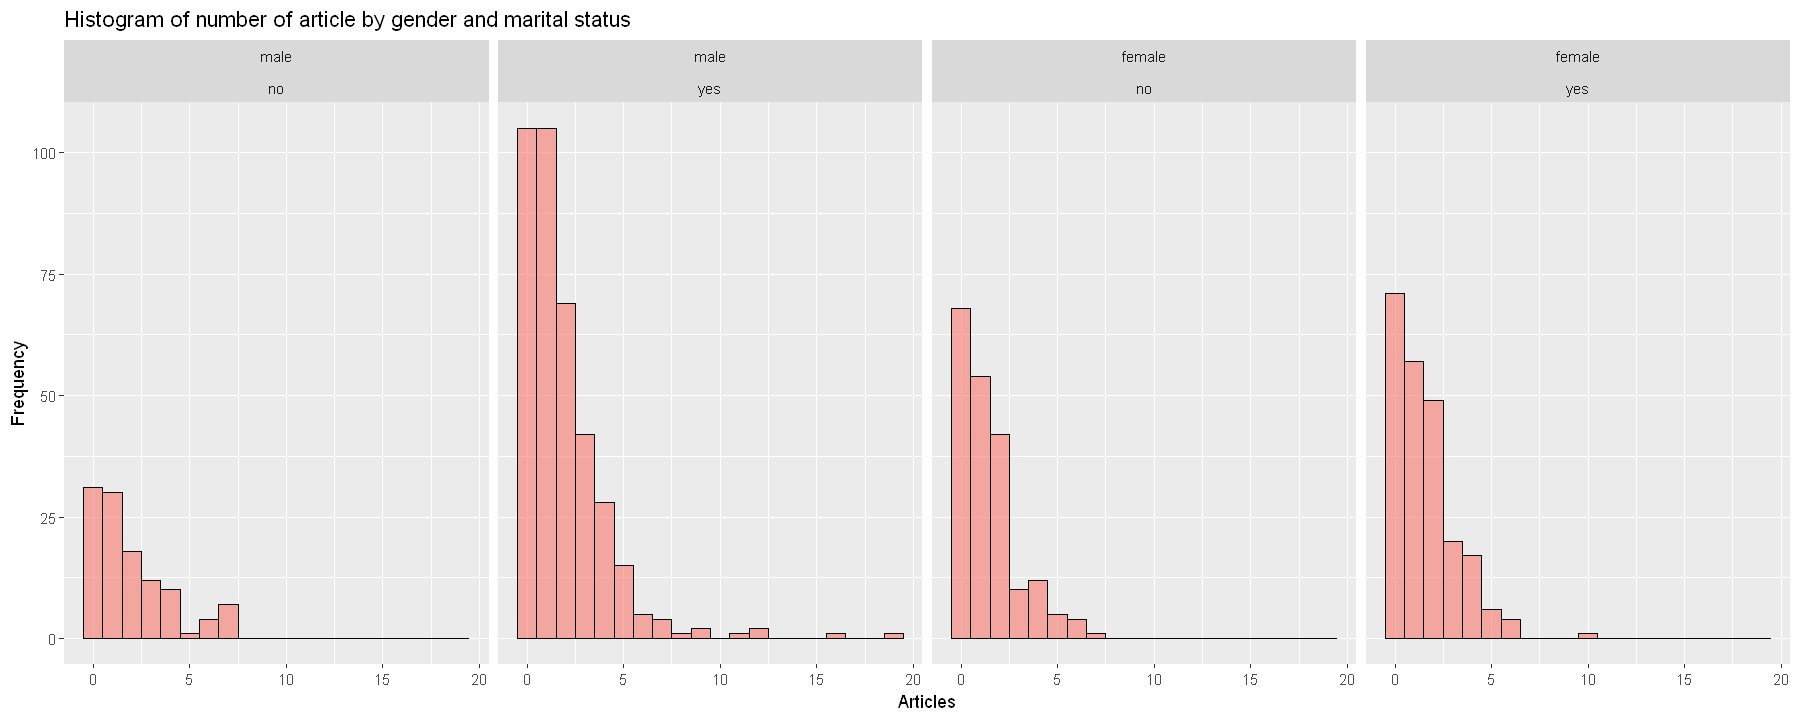

In [30]:
options(repr.plot.width=15, repr.plot.height=6) # to define dimensions for the chart area! I stteled on these numbers!
PhDPublications %>% 
     ggplot(aes(x = articles,
                fill = 'brown')) +
     geom_histogram(binwidth = 1,
                    col = 'black',
                    show.legend = F,
                    alpha = 0.6) +
     labs(title = "Histogram of number of article by gender and marital status",
          x = "Articles",
          y = "Frequency") +
     facet_wrap(gender ~ married,
                nrow = 1)

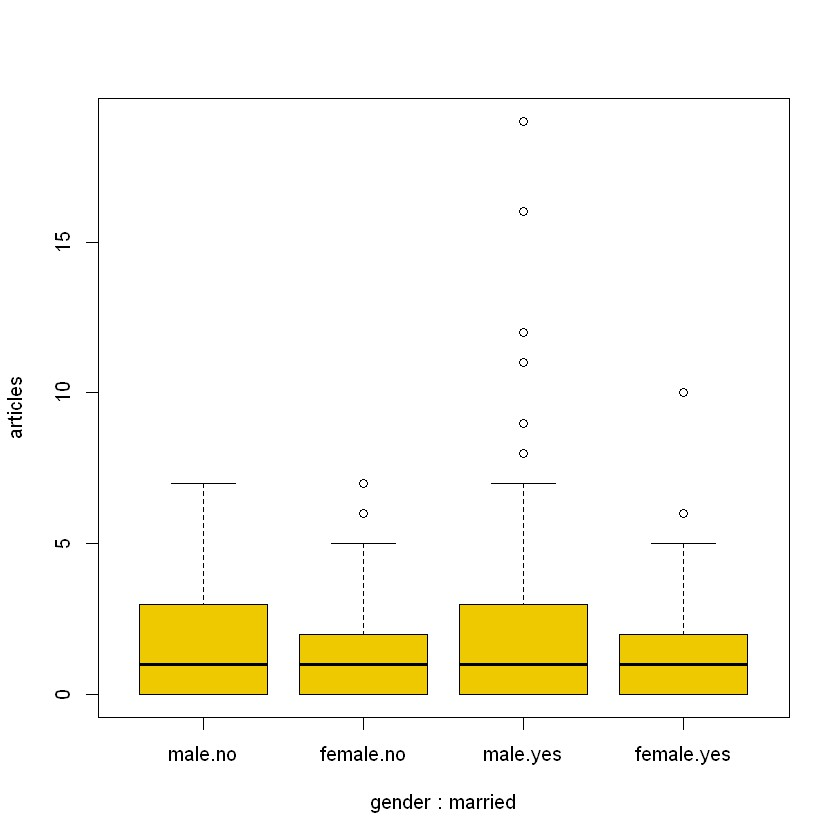

In [32]:
options(repr.plot.width=NULL, repr.plot.height=NULL) # to revert the values to the default so my boxplot looks better
boxplot(articles ~ gender + married, 
        PhDPublications,
        col = "gold2")

first of all, I never thought plots and specifically those done with ggplot in Jupyter show in such quality! Sorry about that! but anyhow:
- I don't see a whole lot of difference between the distributions between categories, medians are all 1
- there is a higher IQR for males than females obviously and seem there is a high variability for married males which can also be verified by their variance to mean value being the highest among these four groups! 

# Modeling - Poisson
Now, it's time to do some modeling. So what it the purpose of this model. I have to say I don't have a research question in mind but just trying to learn count modeling for which I have a myriad of questions when it comes to traffic volume and accident data. So on this one, I'll just have to make up: 

### What is the question?
Let's go with these questions, we have all these in the dataset to help us discuss things: *<u>Is the number of publications a person have related to their gender? to their marital status? their school program? their advisors? how about if they have any childred?*</u>

Back to the types of model, etc., and the discussion that linear regression is not cool with count data and we should use Poisson. We can use the **generalized linear model** approach that allows the dependent variable to follow other types of distributions,  e.g. in logistic regression the response variable is modeled to follow a Bernoulli distribution with a Logit link function, or in Poisson regression, response follows a Poisson distribution, and so on.
> In the context of generalized linear models (GLMs), the link function is used to relate the linear predictor to the response variable. It is a mathematical function that transforms the expected value of the response variable, which is a linear combination of the predictor variables, to the scale of the response variable. In other words, the link function defines how the expected value of the response variable depends on the values of the predictor variables. For example, in a Poisson regression model, the link function is typically the natural logarithm, which transforms the expected value of the response variable to the log scale.

The **Poisson distribution** is a discrete probability distribution (hence good to use for count data) that describes the probability of a given number of events occurring in a fixed interval of time or space, given the average rate of occurrence of the events. It is used to model the count of rare events, such as the number of phone calls received by a call center in an hour or the number of accidents on a highway in a day.
>In probability theory, a discrete probability distribution is a probability distribution characterized by a countable set of possible values. This means that the random variable can only take on certain distinct values with a positive probability, and there are no other values between these possible values that can occur. Examples of discrete probability distributions include the binomial distribution, the Poisson distribution, and the geometric distribution.

The Poisson distribution has several important properties (or **assumptions***, that we want to keep in mind and not violate), including:
* The **mean and variance of the distribution are equal**.
* The distribution is skewed to the right if mean is small, and becomes more symmetric as mean increases (check out this [page](https://statdist.com/distributions/poisson)
* The distribution is unbounded on the right, i.e there is a non-zero probability of observing an arbitrarily large number of events in the right side of distribution.
* The distribution is often used to **model count data (positive integers)**, but it assumes that the **events are independent and occur randomly, with a constant rate of occurrence**.

The `glm()` can help do the generalized linear model and if we specify `family = "Poisson"` we are telling the glm to use the poisson link function in the model. [Here](https://www.dataquest.io/blog/tutorial-poisson-regression-in-r/) is a good page for a lot more details.

I am going to start with only one numerical variable, the program's prestige and go from there. But let's take a look at the pairwise scatter plot of all variables and a correlation between articles and prestige, then move on with the modeling.

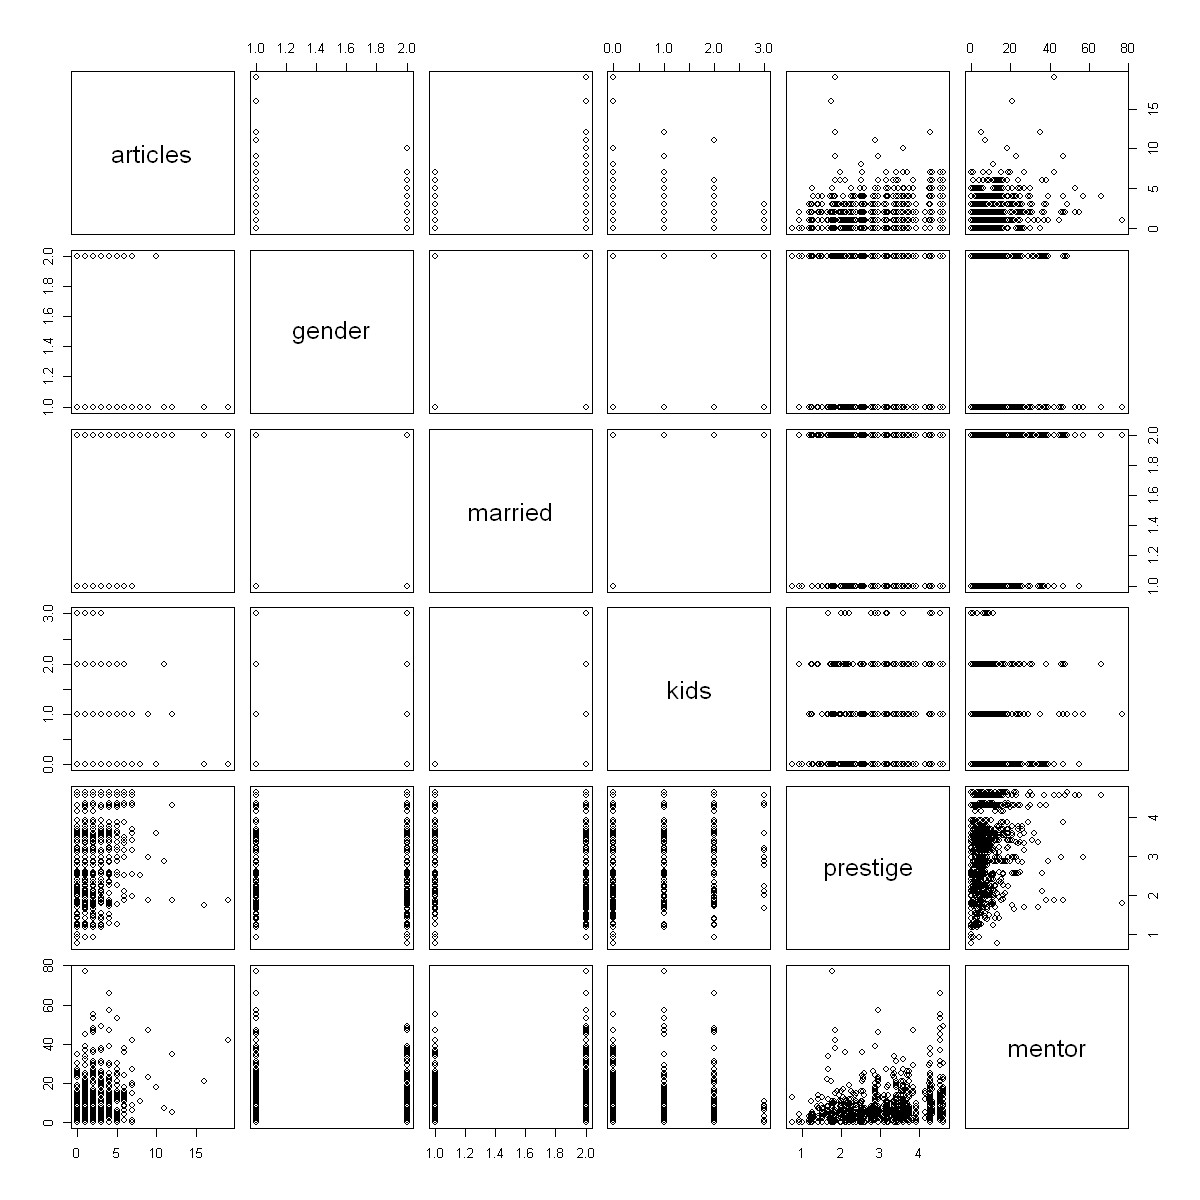

In [39]:
options(repr.plot.width=10, repr.plot.height=10)
plot(PhDPublications)

Looks like number of articles a student has might have a positive relationship with marital status (like we saw before), prestige, and the number of articles their mentor had. On the contrary it looks like there is negative relationship between the articles and number of kids! Oh those kids troubling their parents!

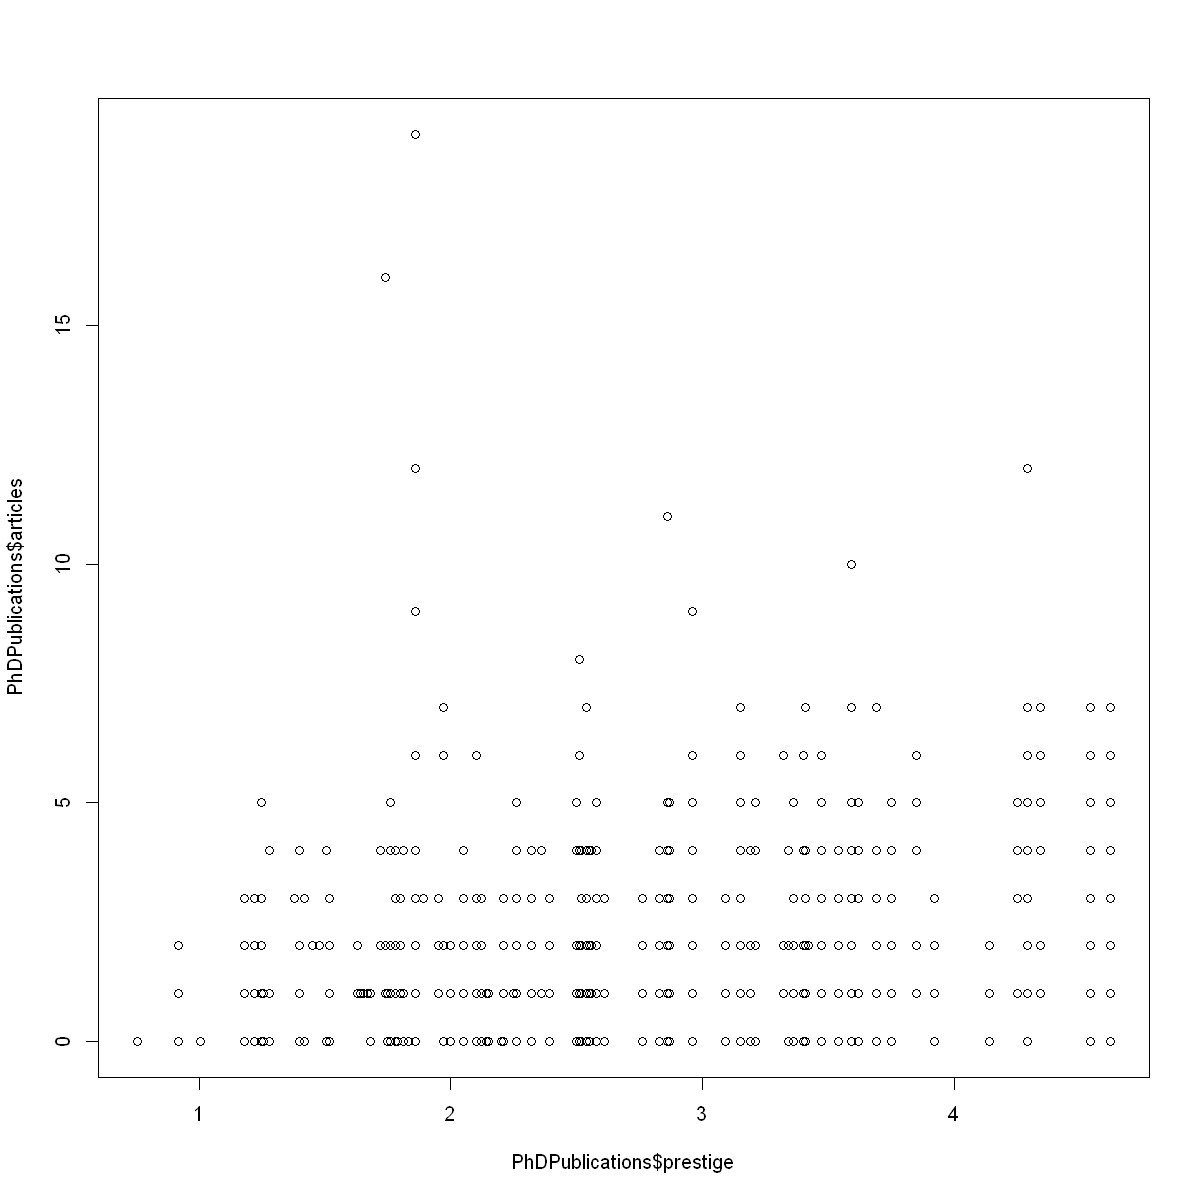

In [47]:
plot(PhDPublications$prestige, PhDPublications$articles)

In [45]:
cor(PhDPublications$articles, PhDPublications$prestige)
cor(PhDPublications$articles, PhDPublications$prestige, method = "spearman")
cor(PhDPublications$articles, PhDPublications$prestige, method = "kendall")

[1] 0.07333861

[1] 0.1105263

[1] 0.08150155

Based on the correlations above, I don't see a lot of relationship but worth a shot right?!
> Correlation between two variables is a statistical measure that indicates the extent to which two variables are related. It is a measure of the strength and direction of the linear relationship between two variables. The correlation coefficient ranges from -1 to 1, with -1 indicating a perfect negative correlation and 1 indicating a perfect positive correlation. If the relationship between two variables is non-linear, I can use a different measure of association such as *Spearman's rank correlation coefficient* or *Kendall's tau*.

In [34]:
glm(articles ~ prestige, 
    data = PhDPublications,
    family = "poisson") %>% 
     summary()


Call:
glm(formula = articles ~ prestige, family = "poisson", data = PhDPublications)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.9596  -1.7599  -0.4767   0.3878   7.8155  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)   
(Intercept)  0.25818    0.08666   2.979  0.00289 **
prestige     0.08532    0.02601   3.280  0.00104 **
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for poisson family taken to be 1)

    Null deviance: 1817.4  on 914  degrees of freedom
Residual deviance: 1806.6  on 913  degrees of freedom
AIC: 3478.3

Number of Fisher Scoring iterations: 5
